In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, Column #, QTable, hstack, vstack
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import fits
from astropy.constants import G
#from astropy.coordinates import frame_transform_graph
#from astropy.coordinates.matrix_utilities import matrix_transpose

import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
#import galstreams

from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline

import pickle
import emcee
from multiprocessing import Pool
import corner
import time

In [2]:
plt.style.use('notebook')

In [3]:
ham_fiducial = gp.Hamiltonian(gp.MilkyWayPotential())
ham_bovy = gp.Hamiltonian(gp.BovyMWPotential2014())
ham_heavy = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), halo=dict(c=0.95, m=7e11), bulge=dict(m=4e9), disk=dict(m=5.5e10)))

tot_mass = 5.4e11
f_gse = 0.171
mw_mass = tot_mass * (1 - f_gse)
gse_mass = tot_mass * f_gse

mw_part = gp.MilkyWayPotential(halo={'m': mw_mass})
gse = gp.NFWPotential(m=gse_mass, r_s=16, a=1.16, b=1.14, c=1, units=galactic, R=R.from_euler('xyz', (47, 10, 13), degrees=True))
ham_tilt = gp.Hamiltonian(mw_part + gse)

gse_alt = gp.NFWPotential(m=gse_mass, r_s=16, a=1.16, b=1.14, c=1, units=galactic, R=R.from_euler('xyz', (47, -6, 30), degrees=True))
ham_tilt_alt =gp.Hamiltonian(mw_part + gse_alt)

coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

In [4]:
def lnnormal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def lnprior(p, t):
    """Current observational constraints as Gaussian priors"""
    
    lnp = 0
    for e, k in enumerate(ckeys):
        lnp += lnnormal(p[e], t[k][0], t['e_{:s}'.format(k)][0])
    
    return lnp

def lnlike(p, dt, Nstep, t, pos_gap, igap, width):
    """Closest impact"""
    
    c_gc = coord.SkyCoord(ra=t['RAdeg'][0]*t['RAdeg'].unit, dec=t['DEdeg'][0]*t['DEdeg'].unit, 
                          distance=(p[0]*t['plx_adpt'].unit).to(u.kpc, equivalencies=u.parallax()), 
                          pm_ra_cosdec=p[1]*t['pmRA'].unit, pm_dec=p[2]*t['pmDE'].unit, 
                          radial_velocity=p[3]*t['HRV'].unit, frame='icrs')
    w0_gc = gd.PhaseSpacePosition(c_gc.transform_to(gc_frame).cartesian)
    
    orbit_gc = ham.integrate_orbit(w0_gc, dt=dt, n_steps=Nstep)
    pos_gc = np.array([orbit_gc.pos.x, orbit_gc.pos.y, orbit_gc.pos.z])

    dist = np.linalg.norm(pos_gap[:,i_gap:i_gap+Nstep+1] - pos_gc, axis=0)
    lnl = lnnormal(np.min(dist), 0, width)
    
    return (lnl, np.min(dist), np.argmin(dist))

def lnprob(p, dt, Nstep, t, pos_gap, i_gap, width):
    lnp = lnprior(p, t)
    if not np.all(np.isfinite(lnp)):
        return -np.inf
    
    lnl, dmin, imin = lnlike(p, dt, Nstep, t, pos_gap, i_gap, width)
    if not np.all(np.isfinite(lnl)):
        return -np.inf
    
    return (lnl + lnp, dmin, imin*dt.value)

## Fiducial potential, NGC 1851

In [5]:
ham = ham_fiducial
c = pickle.load(open('../data/fits/orbit_gd1.pkl', 'rb'))
pot = 'fiducial'

In [6]:
dt = -0.05*u.Myr
T = 1*u.Gyr
Nstream = 2000
Nstep = np.int(np.abs((T/dt).decompose()))

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
orbit_gap = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep+Nstream)
pos_gap = np.array([orbit_gap.pos.x, orbit_gap.pos.y, orbit_gap.pos.z])
model = orbit_gap.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

In [7]:
phi1_gap = -40.75*u.deg
width = 0.07 #kpc

enum = np.arange(np.size(model.phi1), dtype=int)
ind = np.argmin(np.abs(model.phi1[:Nstream]-phi1_gap))
i_gap = enum[ind]

In [8]:
# globular cluster
name = 'NGC 1851'
tgc = Table.read('../data/gc_best.fits')
ind = [True if name==name_ else False for name_ in tgc['Name']]
t = tgc[ind]

ckeys = ['plx_adpt', 'pmRA', 'pmDE', 'HRV']
p0s = np.array([t[k][0] for k in ckeys])

In [9]:
nwalkers = 64
nsteps = 1024
nth = 3
np.random.seed(4728)

p0 = emcee.utils.sample_ball(p0s, [1e-5, 1e-3, 1e-3, 1e-3], nwalkers)
p0[:,0] = np.abs(p0[:,0])

In [10]:
# test likelihood function
lnprob(p0s, dt, Nstep, t, pos_gap, i_gap, width)

(-1155.9546760817746, 3.382347268839956, -465.90000000000003)

In [11]:
dtype = [('dmin', float), ('tmin', float)]
pool = Pool(nth)
sampler = emcee.EnsembleSampler(nwalkers, p0.shape[1], log_prob_fn=lnprob, pool=pool, 
                                args=(dt, Nstep, t, pos_gap, i_gap, width), blobs_dtype=dtype)
_ = sampler.run_mcmc(p0, nsteps)
pool.close()

In [12]:
pickle.dump(sampler, open('../data/fits/mcmc_dmin_{:s}_{:s}.pkl'.format(pot, name), 'wb'))

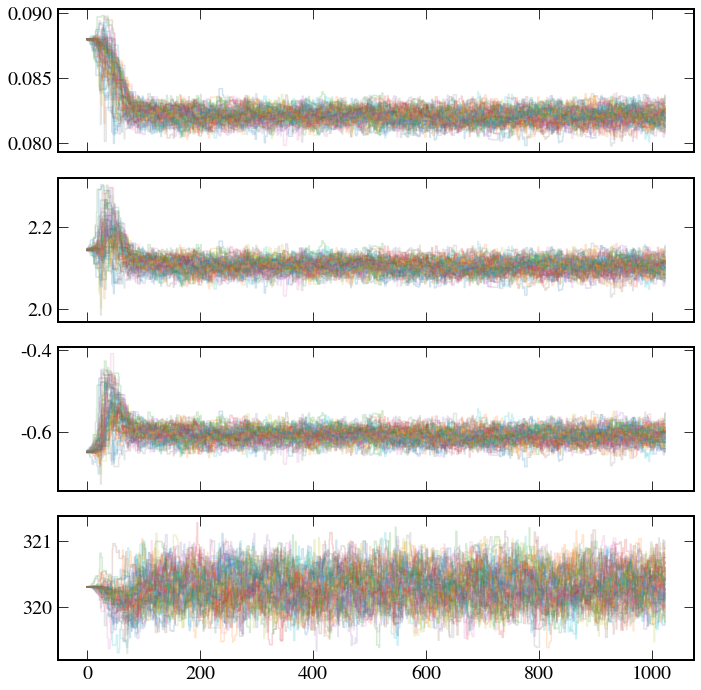

In [13]:
names = ['']

fig, axes = plt.subplots(sampler.ndim, figsize=(10,10), sharex=True, squeeze=False)
    
for k in range(sampler.ndim):
    for walker in sampler.chain[..., k]:
        axes[k][0].plot(walker, marker='', drawstyle='steps-mid', alpha=0.2)

for i in range(len(names)):
    axes[i][0].set_ylabel(names[i])
            
fig.tight_layout()

In [14]:
idx = np.argmax(sampler.get_log_prob(flat=True, discard=512))
pbest = sampler.get_chain(flat=True, discard=512)[idx]
perr = np.std(sampler.get_chain(flat=True, discard=512), axis=0)
print(pbest, perr)

[ 8.20806697e-02  2.10471852e+00 -6.10228427e-01  3.20291225e+02] [0.0005643  0.01720449 0.01734052 0.25358968]


In [15]:
lnprob(pbest, dt, Nstep, t, pos_gap, i_gap, width)

(8.46649537552563, 0.0161608599405638, -472.15000000000003)

In [16]:
p = pbest
c_gc = coord.SkyCoord(ra=t['RAdeg'][0]*t['RAdeg'].unit, dec=t['DEdeg'][0]*t['DEdeg'].unit, 
                          distance=(p[0]*t['plx_adpt'].unit).to(u.kpc, equivalencies=u.parallax()), 
                          pm_ra_cosdec=p[1]*t['pmRA'].unit, pm_dec=p[2]*t['pmDE'].unit, 
                          radial_velocity=p[3]*t['HRV'].unit, frame='icrs')
w0_gc = gd.PhaseSpacePosition(c_gc.transform_to(gc_frame).cartesian)

orbit_gc = ham.integrate_orbit(w0_gc, dt=dt, n_steps=Nstep)
pos_gc = np.array([orbit_gc.pos.x, orbit_gc.pos.y, orbit_gc.pos.z])

dist = np.linalg.norm(pos_gap[:,i_gap:i_gap+Nstep+1] - pos_gc, axis=0)

In [17]:
np.min(dist), np.argmin(dist)*dt

(0.0161608599405638, <Quantity -472.15 Myr>)

## Tilted potential, NGC 1851

In [18]:
ham = ham_tilt
c = pickle.load(open('../data/fits/orbit_gd1_tilt.pkl', 'rb'))
pot = 'tilt'

In [19]:
dt = -0.05*u.Myr
T = 1*u.Gyr
Nstream = 2000
Nstep = np.int(np.abs((T/dt).decompose()))

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
orbit_gap = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep+Nstream)
pos_gap = np.array([orbit_gap.pos.x, orbit_gap.pos.y, orbit_gap.pos.z])
model = orbit_gap.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

In [20]:
phi1_gap = -40.75*u.deg
width = 0.07 #kpc

enum = np.arange(np.size(model.phi1), dtype=int)
ind = np.argmin(np.abs(model.phi1[:Nstream]-phi1_gap))
i_gap = enum[ind]

In [21]:
# globular cluster
name = 'NGC 1851'
tgc = Table.read('../data/gc_best.fits')
ind = [True if name==name_ else False for name_ in tgc['Name']]
t = tgc[ind]

ckeys = ['plx_adpt', 'pmRA', 'pmDE', 'HRV']
p0s = np.array([t[k][0] for k in ckeys])

In [22]:
nwalkers = 64
nsteps = 1024
nth = 3
np.random.seed(4728)

p0 = emcee.utils.sample_ball(p0s, [1e-5, 1e-3, 1e-3, 1e-3], nwalkers)
p0[:,0] = np.abs(p0[:,0])

In [23]:
# test likelihood function
lnprob(p0s, dt, Nstep, t, pos_gap, i_gap, width)

(-567.4727895292175, 2.38183764325238, -467.45000000000005)

In [24]:
dtype = [('dmin', float), ('tmin', float)]
pool = Pool(nth)
sampler2 = emcee.EnsembleSampler(nwalkers, p0.shape[1], log_prob_fn=lnprob, pool=pool, 
                                args=(dt, Nstep, t, pos_gap, i_gap, width), blobs_dtype=dtype)
_ = sampler2.run_mcmc(p0, nsteps)
pool.close()

emcee: Exception while calling your likelihood function:
  params: [ 8.35727443e-02  2.09243534e+00 -6.20516066e-01  3.20042597e+02]
emcee: Exception while calling your likelihood function:
  params: [ 8.48569182e-02  2.13790319e+00 -5.62556148e-01  3.20615424e+02]


Process ForkPoolWorker-4:


  args: (<Quantity -0.05 Myr>, 20000, <Table length=1>
  Name    OName   RAdeg   DEdeg    Dist  ...   plx    e_plx  plx_adpt e_plx_adpt
                   deg     deg     kpc   ...   mas     mas     mas       mas    
bytes11  bytes10 float64 float64 float64 ... float64 float64 float64   float64  
-------- ------- ------- ------- ------- ... ------- ------- -------- ----------
NGC 1851          78.528 -40.047    12.1 ...   0.088   0.011    0.088      0.011, array([[-13.22762044, -13.2287864 , -13.22994509, ...,  -6.08206199,
         -6.07316637,  -6.06426748],
       [ -6.65718418,  -6.64743136,  -6.63767487, ...,  10.43938964,
         10.44638416,  10.45337297],
       [  1.85340835,   1.86118751,   1.86896504, ...,   7.96789791,
          7.96278123,   7.95765963]]), 564, 0.07)
  kwargs: {}
  args: (<Quantity -0.05 Myr>, 20000, <Table length=1>
  Name    OName   RAdeg   DEdeg    Dist  ...   plx    e_plx  plx_adpt e_plx_adpt
                   deg     deg     kpc   ...   mas     mas 

Traceback (most recent call last):


Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


  kwargs: {}
  exception:


  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
Traceback (most recent call last):
KeyboardInterrupt
  File "/usr/lib/python3.6/site-packages/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/usr/lib/python3.6/site-packages/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-4-ede34156916d>", line 35, in lnprob
    lnl, dmin, imin = lnlike(p, dt, Nstep, t, pos_gap, i_gap, width)
  File "<ipython-input-4-ede34156916d>", line 35, in lnprob
    lnl, dmin, imin = lnlike(p, dt, Nstep, t, pos_gap, i_gap, width)
  File "<ipython-input-4-ede34156916d>", line 20, in lnlike
    w0_gc = gd.PhaseSpacePosition(c_gc.tran

KeyboardInterrupt: 

  File "/usr/lib64/python3.6/site-packages/astropy/units/core.py", line 808, in is_equivalent
    return self._is_equivalent(other, equivalencies)
  File "/usr/lib64/python3.6/site-packages/astropy/units/core.py", line 819, in _is_equivalent
    if (self._get_physical_type_id() ==
  File "/usr/lib64/python3.6/site-packages/astropy/units/core.py", line 539, in _get_physical_type_id
    r = zip([x.name for x in unit.bases], unit.powers)
  File "/usr/lib64/python3.6/site-packages/astropy/units/core.py", line 539, in <listcomp>
    r = zip([x.name for x in unit.bases], unit.powers)
  File "/usr/lib64/python3.6/site-packages/astropy/units/core.py", line 1609, in name
    @property
KeyboardInterrupt


In [ ]:
pickle.dump(sampler2, open('../data/fits/mcmc_dmin_{:s}_{:s}.pkl'.format(pot, name), 'wb'))

In [ ]:
names = ['']

fig, axes = plt.subplots(sampler2.ndim, figsize=(10,10), sharex=True, squeeze=False)
    
for k in range(sampler2.ndim):
    for walker in sampler2.chain[..., k]:
        axes[k][0].plot(walker, marker='', drawstyle='steps-mid', alpha=0.2)

for i in range(len(names)):
    axes[i][0].set_ylabel(names[i])
            
fig.tight_layout()

In [ ]:
idx = np.argmax(sampler2.get_log_prob(flat=True, discard=512))
# idx = np.argmin(sampler.get_log_prob(flat=True, discard=256))
pbest = sampler2.get_chain(flat=True, discard=512)[idx]
perr = np.std(sampler2.get_chain(flat=True, discard=512), axis=0)
print(pbest, perr)

In [ ]:
lnprob(pbest, dt, Nstep, t, pos_gap, i_gap, width)

In [ ]:
p = pbest
c_gc = coord.SkyCoord(ra=t['RAdeg'][0]*t['RAdeg'].unit, dec=t['DEdeg'][0]*t['DEdeg'].unit, 
                          distance=(p[0]*t['plx_adpt'].unit).to(u.kpc, equivalencies=u.parallax()), 
                          pm_ra_cosdec=p[1]*t['pmRA'].unit, pm_dec=p[2]*t['pmDE'].unit, 
                          radial_velocity=p[3]*t['HRV'].unit, frame='icrs')
w0_gc = gd.PhaseSpacePosition(c_gc.transform_to(gc_frame).cartesian)

orbit_gc = ham.integrate_orbit(w0_gc, dt=dt, n_steps=Nstep)
pos_gc = np.array([orbit_gc.pos.x, orbit_gc.pos.y, orbit_gc.pos.z])

dist = np.linalg.norm(pos_gap[:,i_gap:i_gap+Nstep+1] - pos_gc, axis=0)

In [ ]:
np.min(dist), np.argmin(dist)*dt

## Alternative tilted potential, NGC 1851

In [ ]:
ham = ham_tilt_alt
c = pickle.load(open('../data/fits/orbit_gd1_tilt.pkl', 'rb'))
pot = 'tilt_alt'

In [ ]:
dt = -0.05*u.Myr
T = 1*u.Gyr
Nstream = 2000
Nstep = np.int(np.abs((T/dt).decompose()))

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
orbit_gap = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep+Nstream)
pos_gap = np.array([orbit_gap.pos.x, orbit_gap.pos.y, orbit_gap.pos.z])
model = orbit_gap.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

In [ ]:
phi1_gap = -40.75*u.deg
width = 0.07 #kpc

enum = np.arange(np.size(model.phi1), dtype=int)
ind = np.argmin(np.abs(model.phi1[:Nstream]-phi1_gap))
i_gap = enum[ind]

In [ ]:
# globular cluster
name = 'NGC 1851'
tgc = Table.read('../data/gc_best.fits')
ind = [True if name==name_ else False for name_ in tgc['Name']]
t = tgc[ind]

ckeys = ['plx_adpt', 'pmRA', 'pmDE', 'HRV']
p0s = np.array([t[k][0] for k in ckeys])

In [ ]:
nwalkers = 64
nsteps = 1024
nth = 3
np.random.seed(4728)

p0 = emcee.utils.sample_ball(p0s, [1e-5, 1e-3, 1e-3, 1e-3], nwalkers)
p0[:,0] = np.abs(p0[:,0])

In [ ]:
# test likelihood function
lnprob(p0s, dt, Nstep, t, pos_gap, i_gap, width)

In [ ]:
dtype = [('dmin', float), ('tmin', float)]
pool = Pool(nth)
sampler3 = emcee.EnsembleSampler(nwalkers, p0.shape[1], log_prob_fn=lnprob, pool=pool, 
                                args=(dt, Nstep, t, pos_gap, i_gap, width), blobs_dtype=dtype)
_ = sampler3.run_mcmc(p0, nsteps)
pool.close()

In [ ]:
pickle.dump(sampler3, open('../data/fits/mcmc_dmin_{:s}_{:s}.pkl'.format(pot, name), 'wb'))

In [ ]:
names = ['']

fig, axes = plt.subplots(sampler3.ndim, figsize=(10,10), sharex=True, squeeze=False)
    
for k in range(sampler3.ndim):
    for walker in sampler3.chain[..., k]:
        axes[k][0].plot(walker, marker='', drawstyle='steps-mid', alpha=0.2)

for i in range(len(names)):
    axes[i][0].set_ylabel(names[i])
            
fig.tight_layout()

In [ ]:
idx = np.argmax(sampler3.get_log_prob(flat=True, discard=512))
pbest = sampler3.get_chain(flat=True, discard=512)[idx]
perr = np.std(sampler3.get_chain(flat=True, discard=512), axis=0)
print(pbest, perr)

In [ ]:
lnprob(pbest, dt, Nstep, t, pos_gap, i_gap, width)

In [ ]:
p = pbest
c_gc = coord.SkyCoord(ra=t['RAdeg'][0]*t['RAdeg'].unit, dec=t['DEdeg'][0]*t['DEdeg'].unit, 
                          distance=(p[0]*t['plx_adpt'].unit).to(u.kpc, equivalencies=u.parallax()), 
                          pm_ra_cosdec=p[1]*t['pmRA'].unit, pm_dec=p[2]*t['pmDE'].unit, 
                          radial_velocity=p[3]*t['HRV'].unit, frame='icrs')
w0_gc = gd.PhaseSpacePosition(c_gc.transform_to(gc_frame).cartesian)

orbit_gc = ham.integrate_orbit(w0_gc, dt=dt, n_steps=Nstep)
pos_gc = np.array([orbit_gc.pos.x, orbit_gc.pos.y, orbit_gc.pos.z])

dist = np.linalg.norm(pos_gap[:,i_gap:i_gap+Nstep+1] - pos_gc, axis=0)

In [ ]:
np.min(dist), np.argmin(dist)*dt

In [25]:
pool.close()